In [1]:
from sklearn.preprocessing import RobustScaler
import numpy as np
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

# Spotify Popularity Predictor (39%)

The goal of this challenge is to create a model that predicts the popularity of a song based on its features.

The dataset contains a list of tracks with the following characteristics:
- `acousticness`: whether the track is acoustic
- `danceability`: describes how suitable a track is for dancing
- `duration_ms`: duration of the track in milliseconds
- `energy`: represents a perceptual measure of intensity and activity
- `explicit`: whether the track has explicit lyrics
- `id`: id for the track
- `instrumentalness`: predicts whether a track contains no vocals
- `key`: the key the track is in
- `liveness`: detects the presence of an audience in the recording
- `loudness`: the overall loudness of a track in decibels
- `mode`: modality of a track
- `name`: name of the track
- `popularity`: popularity of the track
- `release_date`: release date
- `speechiness`: detects the presence of spoken words in a track
- `tempo`: overall estimated tempo of a track in beats per minute
- `valence`: describes the musical positiveness conveyed by a track
- `artist`: artist who performed the track

# Model

## Data collection

**📝 Load the `spotify_popularity_train.csv` dataset from the provided URL. Display the first few rows. Perform the usual cleaning operations. Store the result in a `DataFrame` named `data`.**

👉 Do not forget to clean the dataset

In [2]:
url = "https://wagon-public-datasets.s3.amazonaws.com/certification_paris_2021Q1/spotify_popularity_train.csv"

In [3]:
import pandas as pd
data = pd.read_csv(url)
data.head(3)

,acousticness,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,artist
0,0.65400,0.499,219827,0.190,0,0B6BeEUd6UwFlbsHMQKjob,0.00409,7,0.0898,-16.435,1,Back in the Goodle Days,40,1971,0.0454,149.460,0.4300,John Hartford
1,0.00592,0.439,483948,0.808,0,5Gpx4lJy3vKmIvjwbiR5c8,0.14000,2,0.0890,-8.497,1,Worlds Which Break Us - Intro Mix,22,2015-02-02,0.0677,138.040,0.0587,Driftmoon
2,0.73400,0.523,245693,0.288,0,7MxuUYqrCIy93h1EEHrIrL,0.00000,0,0.0771,-11.506,1,I'm The Greatest Star,40,1968-09-01,0.2140,75.869,0.4640,Barbra Streisand


In [4]:
#Checking the number of missing values
data.isnull().sum().sort_values(ascending=False)

#Replacing missing artists
data.artist.replace(np.nan, "Unknown", inplace=True)

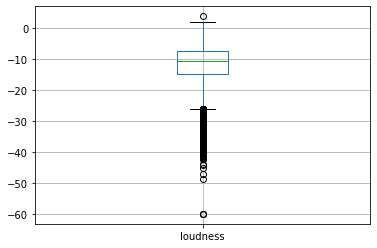

In [5]:
#Checking distribution and identifying outliers
data[['loudness']].boxplot()

#Using a Robust Scaler on Loudness
r_scaler = RobustScaler()
r_scaler.fit(data[['loudness']])
data['loudness'] = r_scaler.transform(data[['loudness']])

In [6]:
#Harmonizing release date keeping the year only
def year_only(date):
    date = date[0:4]
    return date
    
data['year'] = data.release_date.apply(year_only)

### Save your results

Run the following cell to save your results.

In [7]:
from nbresult import ChallengeResult

ChallengeResult(
    "c5_data_cleaning",
    data=data).write()

## Baseline

**📝 We want to use a metric that measures the prediction error in the same unit than `popularity`. In addition, it should strongly penalize largest errors. Which sklearn's [metric](https://scikit-learn.org/stable/modules/model_evaluation.html) should we use? Store its exact name as string below**

In [8]:
scoring = "mean squared error"
#we will use the root mean squared error to both strongly penalize errors and measure the prediction error in the same unit as popularity

**📝 Let's build a baseline model using only the numerical features in our dataset.**
- Build `X_baseline` with only numerical features
- Build `y` your target containing the `popularity`
- Then 5 times cross validate the baseline linear model of your choice (do not fine tune it)
- Store your mean performance in a `float` variable named `baseline_score`

In [9]:
# Preparing X and y
X_baseline = data[['acousticness', 'artist', 'danceability', 'duration_ms', 'energy', 'explicit', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'year', 'speechiness', 'tempo', 'valence']]
y = data[['popularity']]

# Baseline model that predicts "median"
baseline_model = DummyRegressor(strategy="median") 

# cross validate baseline
cv_results = cross_validate(baseline_model, X_baseline, y) 
baseline_score = cv_results['test_score'].mean()
baseline_score

-0.0008176493102242333

### Save your results

Run the following cell to save your results.

In [10]:
from nbresult import ChallengeResult

ChallengeResult(
    "baseline",
    scoring=scoring,
    baseline_score=baseline_score).write()

## Feature engineering

Let's now use the features that we left aside: `release_date` and `artist` to improve the performance of our model. We'll create them manually in a train vs. test context first (and pipeline them later)

### holdout
**📝 Create the 4 variables `X_train` `y_train`, `X_test`, `y_test` with a 50% split with random sampling**

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_baseline, y, test_size=0.5)

### year

**📝 Create `X_train_year` and `X_test_year` by adding the new column `year` containing the release year of the track as integer**

In [12]:
X_train_year = X_train
X_test_year = X_test

### artist

How could we use the `artist` column? There are too many artists to one hot encode it.  
We could instead create an `artist_popularity` feature containing the mean popularity of an artist, computed as the mean popularity of all tracks the artist released _on the train set_.

#### Process artist popularity from the Training set

**📝 Compute and store the `artist_popularity` as a new pandas `Series`**  

In [13]:
data_grouped_train = data.iloc[X_train.index].groupby(by='artist').mean()
data_grouped_train = data_grouped_train.rename(columns={'popularity': 'artist_popularity'})

In [14]:
data_grouped_train

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,artist_popularity,speechiness,tempo,valence
artist,,,,,,,,,,,,,,
"""Test for Victor Young""",0.927000,0.734000,175693.000000,0.474000,0.0,0.076200,10.000000,0.737000,0.037924,1.000000,3.000000,0.256000,132.788000,0.902000
"""Weird Al"" Yankovic",0.150873,0.694091,253804.909091,0.664909,0.0,0.000004,5.363636,0.183555,0.137818,0.545455,37.545455,0.080036,140.977364,0.719636
$NOT,0.190000,0.902000,167147.000000,0.462000,1.0,0.000002,7.000000,0.094000,0.387439,1.000000,72.000000,0.097900,103.984000,0.646000
$tar$eed,0.037500,0.923000,130375.000000,0.172000,1.0,0.020200,10.000000,0.082700,-0.648198,0.000000,0.000000,0.385000,100.046000,0.176000
$uicideBoy$,0.167350,0.817500,127873.500000,0.736500,1.0,0.293265,1.000000,0.335500,0.862157,1.000000,65.500000,0.054550,108.006000,0.146650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
葛蘭,0.947000,0.337000,210427.000000,0.240000,0.0,0.000000,3.000000,0.107000,-0.083647,1.000000,4.000000,0.036300,115.567000,0.297000
許冠英,0.644000,0.490000,190453.000000,0.372000,0.0,0.000001,5.000000,0.367000,0.237359,1.000000,32.000000,0.028000,113.448000,0.500000
邰正宵,0.589000,0.570000,255000.000000,0.474000,0.0,0.000003,0.000000,0.146000,0.227273,0.000000,40.000000,0.028900,139.943000,0.331000


#### Apply the artist popularity to `X_train_year`

**📝 Create a new DataFrame `X_train_engineered` which adds a new column to the existing `X_train_year` with the `artist_popularity` corresponding to the song's artist.** 

🚨 Make sure that the target `popularity` does not end up in `X_train_engineered` 

In [15]:
X_train_engineered = X_train_year.copy()
X_train_engineered = X_train_engineered.set_index('artist')
X_train_engineered['artist_popularity'] = data_grouped_train['artist_popularity']
X_train_engineered

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,year,speechiness,tempo,valence,artist_popularity
artist,,,,,,,,,,,,,,,
Walter Brennan,0.900000,0.531,198053,0.1990,0,0.000029,9,0.2490,-0.446342,1,1962,0.0386,116.447,0.415,12.500000
Vicente Fernández,0.592000,0.522,214507,0.3090,0,0.000075,10,0.1080,-0.041286,1,1977,0.0277,102.785,0.501,42.542857
Giacomo Rondinella,0.984000,0.378,202083,0.1870,0,0.013200,0,0.1530,-0.719069,1,1942,0.0524,135.428,0.222,0.333333
Incubus,0.000119,0.510,198787,0.9400,0,0.200000,4,0.2570,0.735342,1,1999,0.0596,150.076,0.471,53.500000
Rick Springfield,0.291000,0.800,180360,0.7120,0,0.000000,1,0.1450,0.182087,0,1982,0.0419,123.211,0.667,30.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
The Modern Jazz Quartet,0.953000,0.579,262467,0.0889,0,0.007060,0,0.0870,-0.962480,1,1953,0.0546,67.530,0.224,19.076923
Lin-Manuel Miranda,0.312000,0.718,142044,0.4840,0,0.000000,11,0.1270,0.060516,1,2015,0.5230,113.855,0.692,59.000000
Skyrend,0.533000,0.725,296784,0.5540,0,0.877000,8,0.1250,-0.568451,0,2021,0.1130,128.018,0.470,0.000000


#### Apply the artist popularity to `X_test_year`

**📝 Similarily, create a new DataFrame `X_test_engineered` which also adds a new column to the existing `X_test_year` with the `artist_popularity` corresponding to the song's artist, computed from the training set.**

🚨**If an artist has never been seen in the training set, use the global mean popularity of all the tracks of `X_train`**

In [16]:
X_test_engineered = X_test_year.copy()
X_test_engineered = X_test_engineered.set_index('artist')
X_test_engineered['artist_popularity'] = data_grouped_train['artist_popularity']

In [17]:
y_train['popularity'].mean()

25.758582460432756

In [18]:
X_test_engineered.artist_popularity.replace(np.nan, y_train['popularity'].mean(), inplace=True)

### Save your results

Run the following cell to save your results.

In [19]:
from nbresult import ChallengeResult

_ = pd.concat([X_train_engineered, X_test_engineered])

ChallengeResult("c7_feature_engineering",
    shape = _.shape,
    cols = _.columns,
    years = _.get("year"),
    popularities = _.get("artist_popularity"),
).write()

### Performance

**📝 Let's see how these features impact the performance of our model. Retrain the same baseline model on numerical values only, but adding the new features `year` and `artist_popularity`, and see how the performance is impacted. Save the performance in a `float` variable named `score_engineered`**

👉 Do not fine tune the model yet

In [20]:
X_train_engineered

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,year,speechiness,tempo,valence,artist_popularity
artist,,,,,,,,,,,,,,,
Walter Brennan,0.900000,0.531,198053,0.1990,0,0.000029,9,0.2490,-0.446342,1,1962,0.0386,116.447,0.415,12.500000
Vicente Fernández,0.592000,0.522,214507,0.3090,0,0.000075,10,0.1080,-0.041286,1,1977,0.0277,102.785,0.501,42.542857
Giacomo Rondinella,0.984000,0.378,202083,0.1870,0,0.013200,0,0.1530,-0.719069,1,1942,0.0524,135.428,0.222,0.333333
Incubus,0.000119,0.510,198787,0.9400,0,0.200000,4,0.2570,0.735342,1,1999,0.0596,150.076,0.471,53.500000
Rick Springfield,0.291000,0.800,180360,0.7120,0,0.000000,1,0.1450,0.182087,0,1982,0.0419,123.211,0.667,30.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
The Modern Jazz Quartet,0.953000,0.579,262467,0.0889,0,0.007060,0,0.0870,-0.962480,1,1953,0.0546,67.530,0.224,19.076923
Lin-Manuel Miranda,0.312000,0.718,142044,0.4840,0,0.000000,11,0.1270,0.060516,1,2015,0.5230,113.855,0.692,59.000000
Skyrend,0.533000,0.725,296784,0.5540,0,0.877000,8,0.1250,-0.568451,0,2021,0.1130,128.018,0.470,0.000000


In [23]:
# Preparing X and y
X_baseline = X_train_engineered[['acousticness', 'danceability', 'duration_ms', 'energy', 'explicit', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'year', 'speechiness', 'tempo', 'valence', 'artist_popularity']]
y = y_train[['popularity']]

# Baseline model that predicts "median"
baseline_model = DummyRegressor(strategy="median") 

# cross validate baseline
cv_results = cross_validate(baseline_model, X_baseline, y) 
score_engineered = cv_results['test_score'].mean()
score_engineered

-0.00019897927577541274

### Save your results

Run the following cell to save your results.

In [24]:
from nbresult import ChallengeResult

ChallengeResult(
    "c7_score_engineering",
    scoring=scoring,
    score_engineered=score_engineered).write()

## Pipelining

**📝 Let's create a full sklearn preprocessing pipeline called `preproc`. It should integrate our feature engineering for `year` and `artist_popularity`, as well as any other preprocessing of your choice**

**Store also the number of columns/feature after preprocessing your inputs in a variable `col_number`**

**🚨⚠️ Advice: SKIP the `ArtistPopularityTransformer` if you don't have time to do it. It is better for you to have a working pipeline rather than NO pipeline at all**

In [25]:
# 👉 Do not hesitate to reload clean new dataset if you need a fresh start
y = data.popularity
X = data.drop("popularity", axis=1)

In [26]:
# Run this cell to visualize your pipeline as you build it
from sklearn import set_config; set_config(display='diagram')

In [32]:
class ArtistPopularityTransformer(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.BaseEstimator = BaseEstimator
        self.TransformerMixin = TransformerM

    def fit(self, X, y=None):
        """
        process artist mean popularity from artists songs popularity
        process song global mean popularity
        """

        # process artist popularity
        self.artist_popularity = pd.concat([X, y],
                               axis=1,
                               join='inner').groupby(by='artist').mean()['popularity']
        # process mean popularity
        self.mean_train_popularity = y.mean()
        
        return self

    def transform(self, X, y=None):
        """
        apply artist mean popularity vs song global mean popularity to songs
        """

        # inject artist popularity
        X_copy = X.join(self.artist_popularity, on='artist')\
                    .rename(columns={"popularity": "artist_popularity"})\
                    .drop(columns='artist')
        
        # fills popularity of unknown artists with song global mean popularity
        X_copy['artist_popularity'].fillna(self.mean_train_popularity, inplace=True)

        return X_copy # TODO return X_copy

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

year_func = FunctionTransformer(year_only)
year_func = FunctionTransformer(lambda date: year_only(date))

artist_func = FunctionTransformer

preproc = ColumnTransformer([
    ('year_transformer', year_func, ['year'])
    ()])

X(preproc.fit_transform(X)).head()

TypeError: 'DataFrame' object is not callable

#### Save your results

Run the following cell to save your results.

In [ ]:
# Print below your preproc here for the correctors
from sklearn import set_config; set_config(display='diagram')
preproc

In [ ]:
from nbresult import ChallengeResult

ChallengeResult(
    "c6_preprocessing",
    col_number=col_number
).write()

## Training

📝 Time to optimize 

- **Add an estimator to your pipeline (only from scikit-learn)** 

- **Train your pipeline and fine-tune (optimize) your estimator to get the best prediction score**

- **You must create 2 pipelines (one with a linear model, one with an ensemble model)**

Then, 

- Save your two best 5-time cross-validated scores as _float_: `score_linear` and `score_ensemble`

- Save your two best trained pipelines as _Pipeline_ objects: `pipe_linear` and `pipe_ensemble`

### Linear

### Ensemble

### Save your results

Run the following cell to save your results.

In [ ]:
# Print below your best pipe for correction purpose
from sklearn import set_config; set_config(display='diagram')
pipe_linear

In [ ]:
# Print below your best pipe for correction purpose
pipe_ensemble

In [ ]:
from nbresult import ChallengeResult

ChallengeResult("c8_c9_c11_c13_model_tuning",
    scoring = scoring,
    score_linear=score_linear,
    score_ensemble=score_ensemble).write()

## API 

Time to put a pipeline in production!

👉 Go to https://github.com/lewagon/data-certification-api and follow instructions

**This final part is independent from the above notebook**